Ideas

Equal weight, value weight, transaction costs, multiple asset classes, benchmark which one to use (ordinary volatility timing too)?

volatility timing vs downside beta: I get the impression that you can apply the downside beta strategy on more stuff than vol. timing which goes best with momentum etc.

include all the different usual metrics, sharpe, info, drawdown, ...

model robustness to different specifications of the threshold

what are the risks of the strategy: when market is down, stocks tend to move together...

# Plan

Estimate $\beta$ and $\beta^-$ for each year,  signal is $\beta^- - \beta$ (larger is better). Roll sample forward one month at a month to reestimate.

# Code

In [2]:
import qpm
import pandas as pd
import numpy as np
from tqdm import tqdm
from get_signal import get_signal

Currency *ETF

FXY (Japanese Yen), FXE (Euro), FXF (Swiss Franc), FXB (British Pound), FXA (Australian Dollar), FXC (Canadian Dollar)

In [3]:
_DATA_DIR = '../Data'
_STRATEGY_DIR = '../Strategy'
_STRATEGY_NAME = 'Currency'

_SAMPLE_START = '2006-01-01' # Earliest available for currency ETF: 2006-01-03
_SAMPLE_END = '2023-07-31'

In [110]:
df = pd.read_parquet('../Data/ETFdata.parquet')

In [90]:
df_monthly = df.groupby(['ticker', 'ym'], as_index=False)['retM'].first()

In [91]:
df_monthly.sort_values(by=['ym', 'ticker'])

,ticker,ym,retM
1773,ADRA,2003-01-01,-0.024894
1978,ADRD,2003-01-01,-0.009497
2183,ADRE,2003-01-01,-0.072464
2425,ADRU,2003-01-01,-0.020167
11347,BBH,2003-01-01,0.049050
...,...,...,...
318377,ZROZ,2023-07-01,-0.040422
318383,ZSB,2023-07-01,0.000671
318558,ZSL,2023-07-01,-0.159378
318586,ZSPY,2023-07-01,0.051538


In [18]:
df = df[df['ticker'].isin(['FXY', 'FXE', 'FXF', 'FXB', 'FXA'])]

In [19]:
df.sort_values(by=['date', 'ticker'], inplace=True)

In [7]:
df.rename(columns={'retd': 'daret', 'date': 'ldate'}, inplace=True)

In [8]:
df.dropna(subset=['daret'])
df['excess_ret'] = df['daret'] - df['rf']
df = df[df['excess_ret'] > -1]

Commodities (ETF)

UCO (crude oil), DBA (agriculture), DBB (base metal), DBP (precious metal), DBE (energy)

In [71]:
_DATA_DIR = '../Data'
_STRATEGY_DIR = '../Strategy'
_STRATEGY_NAME = 'Commodities'

_SAMPLE_START = '2007-02-01' # Earliest available for currency ETF: 2007-02-01
_SAMPLE_END = '2023-07-31'

In [72]:
df = pd.read_parquet('../Data/ETFdata.parquet')

In [73]:
df = df[df['ticker'].isin(['UCO', 'DBA', 'DBB', 'DBP', 'DBE'])]

In [74]:
df.sort_values(by=['date', 'ticker'], inplace=True)

In [75]:
df.rename(columns={'retd': 'daret', 'date': 'ldate'}, inplace=True)

In [76]:
df.dropna(subset=['daret'])
df['excess_ret'] = df['daret'] - df['rf']
df = df[df['excess_ret'] > -1]

Corporate bonds

In [177]:
df = pd.read_parquet(f'{_DATA_DIR}/daily_data.parquet')

In [204]:
df_bond = pd.read_parquet('../Data/bond_data.parquet').rename(columns={'mktrf': 'benchmark', 'ldate' : 'ym'})

In [197]:
df = pd.read_parquet(f'{_DATA_DIR}/bond_data.parquet')

In [198]:
_DATA_DIR = '../Data'
_STRATEGY_DIR = '../Strategy'
_STRATEGY_NAME = 'Bonds'

In [200]:
df.dropna(subset=['daret'])
df['excess_ret'] = df['daret'] - df['rf']
df = df[df['excess_ret'] > -1]

# Prepare rolling windows
start_date = df['ldate'].iloc[0]
end_date = df['ldate'].iloc[-1]

date_ranges = pd.date_range(start=start_date, end=end_date - pd.DateOffset(months=10), freq='M').to_period('M')

windows = [(str(date), str(date + 12)) for date in date_ranges]

# Calculate signals
signals_rolling = []

for window_start, window_end in tqdm(windows):
    df_year = df[(df['ldate'] > window_start) & (df['ldate'] < window_end)]
    signals_rolling.append(get_signal(df_year, 'cusip'))

signals_rolling = pd.concat(signals_rolling)

# Reformat date to first of each month for future merging
signals_rolling['ldate'] = signals_rolling['ldate'].values.astype('datetime64[M]')

# Save the signals
signals_rolling.to_parquet(f'{_STRATEGY_DIR}/signals_{_STRATEGY_NAME}.parquet')


100%|█| 229/229 [00:15<00:00, 14.73it/s


In [201]:
df

,cusip,ldate,daret,mktrf,rf,excess_ret
740,552673AM7,2002-07-01,-0.173490,-0.174990,0.0015,-0.174990
741,552673AP0,2002-07-01,-0.173490,-0.174990,0.0015,-0.174990
742,552673AQ8,2002-07-01,-0.173490,-0.174990,0.0015,-0.174990
743,552673AS4,2002-07-01,-0.173490,-0.174990,0.0015,-0.174990
2010,552673AU9,2002-07-01,-0.173490,-0.174990,0.0015,-0.174990
...,...,...,...,...,...,...
2169807,575718AH4,2022-06-01,-0.033421,-0.028983,0.0006,-0.034021
2169808,649322AF1,2022-06-01,-0.025026,-0.028983,0.0006,-0.025626
2169809,649322AH7,2022-06-01,-0.018508,-0.028983,0.0006,-0.019108
2169810,649322AJ3,2022-06-01,-0.078584,-0.028983,0.0006,-0.079184


In [79]:
_DATA_DIR = '../Data'
_STRATEGY_DIR = '../Strategy'
_STRATEGY_NAME = 'Bonds'

_SAMPLE_START = '2002-07-01' # Earliest available for bonds: 2002-07-01
_SAMPLE_END = '2022-06-01'

In [80]:
df = pd.read_parquet('../Data/bond_data.parquet')

In [81]:
df.dropna(subset=['daret'])
df['excess_ret'] = df['daret'] - df['rf']
df = df[df['excess_ret'] > -1]

In [82]:
start_date = pd.to_datetime(_SAMPLE_START)
end_date = pd.to_datetime(_SAMPLE_END)

date_ranges = pd.date_range(start=start_date, end=end_date - pd.DateOffset(months=11), freq='MS').to_period('M')

windows = [(str(date), str(date + 12)) for date in date_ranges]

In [83]:
signals_rolling = []

for window_start, window_end in tqdm(windows):
    df_year = df[(df['ldate'] > window_start) & (df['ldate'] < window_end)]
    signals_rolling.append(get_signal(df_year, 'cusip'))

signals_rolling = pd.concat(signals_rolling)

# Reformat date to first of each month for future merging
signals_rolling['ldate'] = signals_rolling['ldate'].values.astype('datetime64[M]')

# Save the signals
signals_rolling.to_parquet(f'{_STRATEGY_DIR}/signals_{_STRATEGY_NAME}.parquet')

100%|██████████████████████████████| 229/229 [00:15<00:00, 14.54it/s]


Days of down market

In [212]:
import matplotlib.pyplot as plt

In [134]:
df = pd.read_parquet(f'{_DATA_DIR}/daily_data.parquet')
group_name = 'permno'

df.dropna(subset=['daret'])
df['excess_ret'] = df['daret'] - df['rf']
df = df[df['excess_ret'] > -1]

# Prepare rolling windows
start_date = pd.to_datetime('2001-01-01')
end_date = pd.to_datetime('2023-09-29')

date_ranges = pd.date_range(start=start_date, end=end_date - pd.DateOffset(months=11), freq='MS').to_period('M')

windows = [(str(date), str(date + 12)) for date in date_ranges]

In [135]:
list_threshold = []
for window_start, window_end in tqdm(windows):
    df_year = df[(df['ldate'] > window_start) & (df['ldate'] < window_end)]
    mkt = df_year[['mktrf', 'ldate']].groupby('ldate').first()
    list_threshold.append((window_end, mkt.mean()[0]))

100%|█| 262/262 [00:59<00:00,  4.43it/s


In [136]:
df_threshold = pd.DataFrame(list_threshold, columns=['Sample end', 'Threshold'])

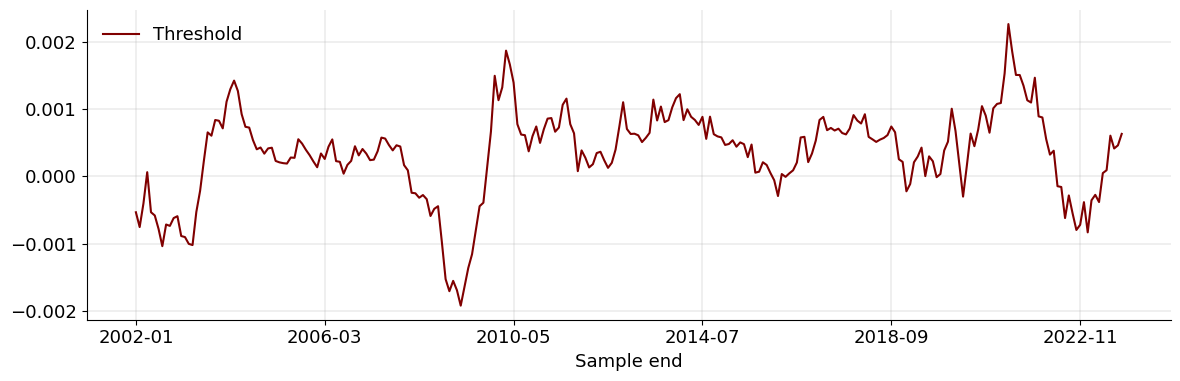

In [142]:
df_threshold.set_index('Sample end').plot()
plt.tight_layout()
plt.savefig('dynamic threshold.png')

In [148]:
list_counts = []
for window_start, window_end in tqdm(windows):
    df_year = df[(df['ldate'] > window_start) & (df['ldate'] < window_end)]
    mkt = df_year[['mktrf', 'ldate']].groupby('ldate').first()
    counts = (mkt < mkt.mean()[0]).sum()
    list_counts.append((window_end, counts[0]))

100%|█| 262/262 [01:00<00:00,  4.34it/s


In [149]:
df_counts = pd.DataFrame(list_counts, columns=['Sample end', 'Counts'])

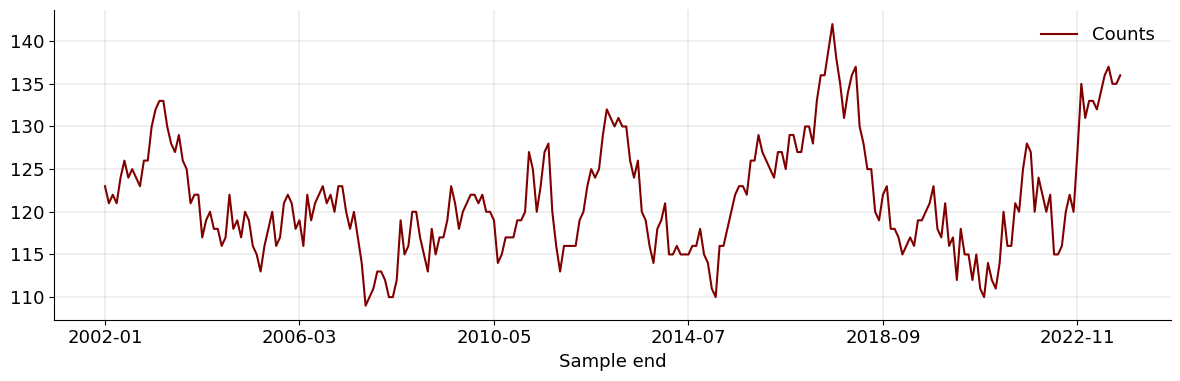

In [153]:
df_counts.set_index('Sample end').plot()
plt.tight_layout()
plt.savefig('counts over time.png')

Verify beta

In [96]:
import statsmodels.api as sm

In [92]:
signals_rolling = pd.read_parquet(f'{_STRATEGY_DIR}/signals_Equity.parquet')

In [93]:
signals_rolling

,permno,signal,ldate
0,10001,-0.115738,2001-12-01
1,10002,-0.076260,2001-12-01
2,10012,-0.390745,2001-12-01
3,10019,-0.189434,2001-12-01
4,10025,-0.568554,2001-12-01
...,...,...,...
4803,93423,-0.371984,2023-09-01
4804,93426,-0.267795,2023-09-01
4805,93427,0.092138,2023-09-01
4806,93434,-0.040885,2023-09-01


In [94]:
df = pd.read_parquet(f'{_DATA_DIR}/daily_data.parquet')
group_name = 'permno'
df.dropna(subset=['daret'])
df['excess_ret'] = df['daret'] - df['rf']
df = df[df['excess_ret'] > -1]

In [95]:
df_year = df[(df['ldate'] > '2001-01') & (df['ldate'] < '2002-01')]

In [100]:
mkt = df_year[['mktrf', 'ldate']].groupby('ldate').first()
threshold = mkt.mean()[0]
down_idx = mkt[mkt['mktrf'] < threshold].index

In [106]:
toy = df_year[df_year['permno']==10001]
toy_down = toy[toy['ldate'].isin(down_idx)]

In [99]:
X = sm.add_constant(toy['mktrf'])
model = sm.OLS(toy['excess_ret'], X)
results = model.fit()
results.params

const    0.001178
mktrf    0.083287
dtype: float64

In [108]:
X = sm.add_constant(toy_down['mktrf'])
model = sm.OLS(toy_down['excess_ret'], X)
results = model.fit()
results.params

const   -0.001487
mktrf   -0.032451
dtype: float64

In [109]:
-0.032451 - 0.083287

-0.11573800000000001

Betting against beta

In [215]:
df_bab = pd.read_csv('../Data/bab_monthly.csv')

In [219]:
df_bab = pd.read_csv('../Data/bab_monthly.csv')
df_bab['date'] = pd.to_datetime(df_bab['date']).values.astype('datetime64[M]')
df_bab = df_bab.sort_values(['date']).rename(columns = {'date': 'ym'})

In [220]:
df_bab

,ym,ret
0,1928-08-01,-0.065800
1,1928-09-01,-0.035360
2,1928-10-01,-0.002491
3,1928-11-01,-0.070345
4,1928-12-01,-0.008096
...,...,...
1128,2022-08-01,-0.003600
1129,2022-09-01,0.041270
1130,2022-10-01,-0.000523
1131,2022-11-01,-0.013750
